# Rod Sheet Dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.solvers.isotropic_solver import bruteforce_isotropic_relax

from tyssue.io import hdf5
from tyssue.draw.threejs_draw import view_3js
from tyssue.draw.plt_draw import quick_edge_draw
%matplotlib inline

from tyssue.utils.utils import _to_2d, _to_3d

from tyssue.draw.plt_draw import plot_forces

Reseting datasets values with new specs


{'height_axis': 'z', 'geometry': 'rod', 'ab': [1.1250404860129168, 0.77774788397141592]}


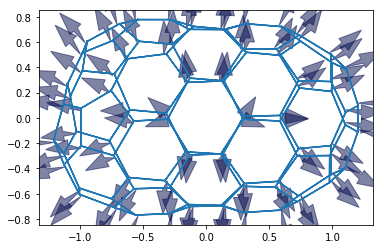

In [2]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('rod', dsets,
              config.geometry.rod_sheet())
geom.reset_scafold(sheet)
geom.update_all(sheet)

dyn_specs = config.dynamics.quasistatic_sheet_spec()
dyn_specs['vert']['basal_shift'] = 0.
dyn_specs['face']['prefered_vol'] = 1.

sheet.update_specs(dyn_specs, reset=True)
geom.update_all(sheet)

fig, ax = plot_forces(sheet, geom, model, list('zx'), scaling=1)

In [3]:
sheet.face_df.area.mean(),   sheet.vert_df['height'].mean(), sheet.face_df.vol.mean()

(0.22684957248815071, 0.78954794955596452, 0.17828887730313822)

In [6]:
model.compute_energy(sheet)

24.41664898263847

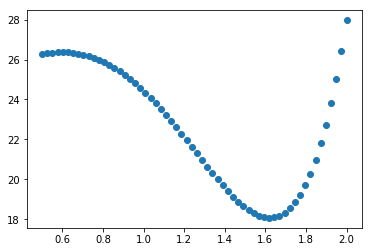

In [7]:
from tyssue.utils import scaled_unscaled

scales = np.linspace(0.8, 2, 50)
energies = [scaled_unscaled(model.compute_energy, scale,
                            sheet, geom, args=(sheet, ))
            for scale in scales]

fig, ax = plt.subplots()
ax.plot(scales, energies)


In [4]:
%pdb

Automatic pdb calling has been turned ON


In [9]:
E_t, E_c, E_v = model.compute_energy(sheet, full_output=True)

In [10]:
from scipy import optimize

def bruteforce_isotropic_relax(sheet, geom, model):
    def to_minimize(scale):
        return scaled_unscaled(model.compute_energy,
            scale, sheet,
            geom, args=[sheet])
    
    return optimize.minimize_scalar(to_minimize, bracket=[1., 3.])

In [11]:
res = bruteforce_isotropic_relax(sheet, geom, model)
geom.scale(sheet, res['x'], sheet.coords)
geom.update_all(sheet)


In [12]:
res = bruteforce_isotropic_relax(sheet, geom, model)
print("Scaling by factor {:.3f}".format(res['x']))
geom.reset_scafold(sheet)


,x,y,z
srce,,,
0,0.094870,0.077112,0.077885
1,-0.040768,-0.016232,-0.020717
2,-0.085006,-0.048079,-0.001666
3,0.002512,-0.021599,0.009121
4,0.009372,-0.002819,0.016712
5,0.008309,0.016404,0.022120
6,-0.004623,-0.008226,-0.014642
7,-0.003576,-0.003195,-0.011116
8,-0.000804,0.000246,-0.001875


In [13]:
res = Solver.find_energy_min(sheet, geom, model)

In [14]:
res

False

In [15]:
rdr, l = view_3js(sheet)
rdr


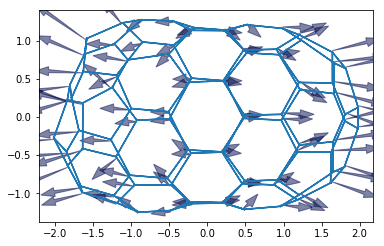

In [17]:
from tyssue.draw.plt_draw import plot_forces
fig, ax = plot_forces(sheet, geom, model, list('zx'), scaling=5)

In [18]:
res = Solver.find_energy_min(sheet, geom, model)
res['success']

{'ab': [1.8376085083736911, 1.2639630010227065],
 'geometry': 'rod',
 'grad_norm_factor': 1.0,
 'height_axis': 'z',
 'nrj_norm_factor': 1.0}

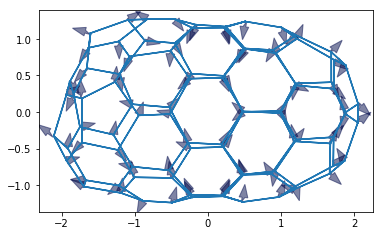

In [14]:
fig, ax = plot_forces(sheet, geom, model, list('zx'), scaling=5)

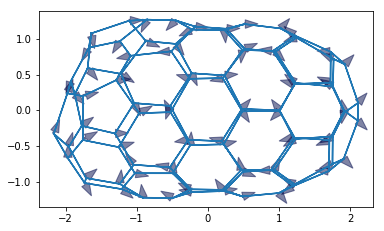

In [34]:
fig, ax = plot_forces(sheet, geom, model, list('zx'),
                      scaling=5, approx_grad=Solver.approx_grad)